In [1]:
#Import necessary libraries
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import zscore
from sklearn.metrics import log_loss,roc_auc_score,recall_score,plot_roc_curve
from sklearn import datasets, metrics

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist

# Data loading and preprocessing

In [2]:
df_custdata = pd.read_excel('Credit Card Customer Data.xlsx')

In [3]:
print('')
print('Count of rows and columns present in dataset')
print('')
df_custdata.shape


Count of rows and columns present in dataset



(660, 7)

There are 660 rows and 7 columns in the dataset

In [4]:
df_custdata.isnull().values.any() # If there are any null values in data set

False

There are no NULL values in the dataset

In [5]:
df_custdata.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


In [6]:
print('')
print('Info about dataset')
print('')
df_custdata.info()


Info about dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


# Observation

There are 660 records in the dataset

There are 7 variables that define the dataset
    
    5 variables that add value to the task at hand - grouping customers: 
            Avg_Credit_Limit - average credit limit
            Total_Credit_Cards - # of credit cards
            Total_visits_bank - # of times customer visited bank
            Total_visits_online - # of times customer contacted bank through the website
            Total_calls_made - # of times customer contacted bank through the call center
        
    and 2 variables that do not impact grouping of customers
        SL_No - Serial number, which is a surrogate key generated to link dataset with other related datasets
        Customer Key - Customer identifier to uniquely identify a customer

    All features are integer values. Hence, no type conversion is needed.

    Avg_Credit_Limit is defined in USD/currency unit while all other variables are defined as counts.

    
    The two variables Sl_No and Customer Key appear to be non-influential. We can decide on whether to drop them based on further analysis of the data.

In [7]:
df_custdata.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Sl_No,660.0,330.500000,190.669872,1.0,165.75,330.5,495.25,660.0
Customer Key,660.0,55141.443939,25627.772200,11265.0,33825.25,53874.5,77202.50,99843.0
Avg_Credit_Limit,660.0,34574.242424,37625.487804,3000.0,10000.00,18000.0,48000.00,200000.0
Total_Credit_Cards,660.0,4.706061,2.167835,1.0,3.00,5.0,6.00,10.0
Total_visits_bank,660.0,2.403030,1.631813,0.0,1.00,2.0,4.00,5.0
Total_visits_online,660.0,2.606061,2.935724,0.0,1.00,2.0,4.00,15.0
Total_calls_made,660.0,3.583333,2.865317,0.0,1.00,3.0,5.00,10.0


In [8]:
# Duplicates Check
[df_custdata.duplicated()] == 'False'

False

In [9]:
# Check for null values
# df_custdata.isnull().apply(pd.value_counts)

df_custdata.isnull().sum()

Sl_No                  0
Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

In [10]:
df_custdata.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


# Observations

    As inferred before, the variables Sl_No and Customer Key can be ignored since these have no influence in the grouping of customers
    
    While there are no NULL values, there are zeroes present in the dataset for 3 variables:
        Total_visits_bank
        Total_visits_online
        Total_calls_made
    This is a valid business scenario and need not be treated for imputation.
    
    There are no duplicate records.
    
    The variables belong to different scales with Avg_Credit_Limit ranging between 3000 and 200000, other variables range between 0 and 15.
    This indicates that the dataset needs to be scaled before being used in any clustering algorithm.

In [11]:
# Create new dataset to be used for training by dropping Sl_No & Customer ID
df_main = df_custdata.copy()

df_main.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


In [12]:
# Drop Sl_No
df_main.drop('Sl_No', axis=1, inplace = True)


# Drop Customer Key
df_main.drop('Customer Key', axis=1, inplace = True)

df_main.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,100000,2,1,1,0
1,50000,3,0,10,9
2,50000,7,1,3,4
3,30000,5,1,1,4
4,100000,6,0,12,3


,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
Avg_Credit_Limit,1.000000,0.608860,-0.100312,0.551385,-0.414352
Total_Credit_Cards,0.608860,1.000000,0.315796,0.167758,-0.651251
Total_visits_bank,-0.100312,0.315796,1.000000,-0.551861,-0.506016
Total_visits_online,0.551385,0.167758,-0.551861,1.000000,0.127299
Total_calls_made,-0.414352,-0.651251,-0.506016,0.127299,1.000000


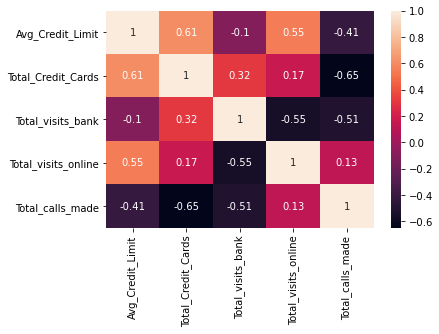

In [13]:
# Correlation Matrix

corr = df_main.corr()
display(corr)
sns.heatmap(corr, annot = True)

    There are no highly correlated variables

# Univariate Analysis

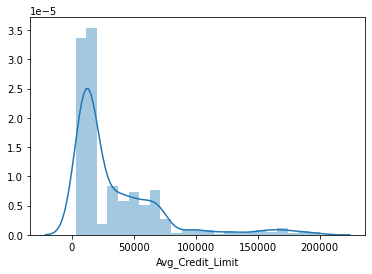

In [14]:
sns.distplot(df_main['Avg_Credit_Limit'])

    The majority of customers have a credit limit of less than 3000 USD.
    There are two major groups of customers based on credit limit - at 1000-2000 range and 3000-6000 range.
    The distribution is skewed towards the right.

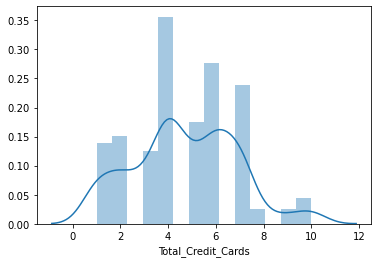

In [15]:
sns.distplot(df_main['Total_Credit_Cards'])

    There are 4 peaks in the graph indicating there could be 4 different groups of customers based on the number of credit cards they hold.

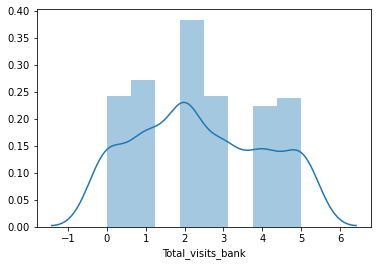

In [16]:
sns.distplot(df_main['Total_visits_bank'])

    Clearly,there is potential for 3 different groups of customers based on the number of times they visited the bank.

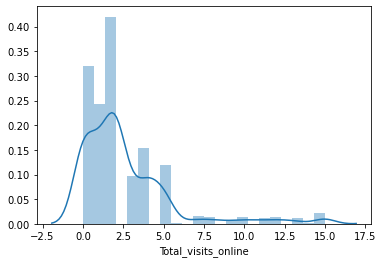

In [17]:
sns.distplot(df_main['Total_visits_online'])

    There appear to be 2 major groups of customers based on the number of times they contacted the bank through online means with a long tail towards the right.

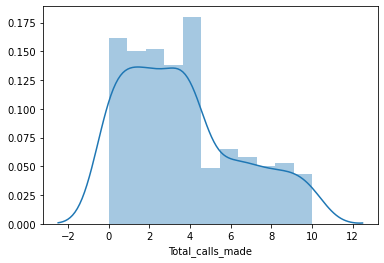

In [18]:
sns.distplot(df_main['Total_calls_made'])

    Based on the number of times they have called the customer care, the customers can be grouped into 3 major groups.

In [19]:
print('-------------------------------------')
for colname in df_main.columns[:-1]:
    q75, q25 = np.percentile(df_main[df_main[colname].name], [75 ,25])
    iqr = q75 - q25
    print('IQR for ',df_main[colname].name,' is:', iqr)
    print('Median for ',df_main[colname].name,' is:', df_main[colname].median())


    limit_lo = q25-1.5*iqr
    limit_uo = q75+1.5*iqr
    print('Lower limit for IQR for',df_main[colname].name,' is: ',limit_lo)
    print('Upper limit for IQR for',df_main[colname].name,' is: ',limit_uo)
    print('-------------------------------------')

-------------------------------------
IQR for  Avg_Credit_Limit  is: 38000.0
Median for  Avg_Credit_Limit  is: 18000.0
Lower limit for IQR for Avg_Credit_Limit  is:  -47000.0
Upper limit for IQR for Avg_Credit_Limit  is:  105000.0
-------------------------------------
IQR for  Total_Credit_Cards  is: 3.0
Median for  Total_Credit_Cards  is: 5.0
Lower limit for IQR for Total_Credit_Cards  is:  -1.5
Upper limit for IQR for Total_Credit_Cards  is:  10.5
-------------------------------------
IQR for  Total_visits_bank  is: 3.0
Median for  Total_visits_bank  is: 2.0
Lower limit for IQR for Total_visits_bank  is:  -3.5
Upper limit for IQR for Total_visits_bank  is:  8.5
-------------------------------------
IQR for  Total_visits_online  is: 3.0
Median for  Total_visits_online  is: 2.0
Lower limit for IQR for Total_visits_online  is:  -3.5
Upper limit for IQR for Total_visits_online  is:  8.5
-------------------------------------


In [20]:
# To create a working copy of dataset
df_work = df_main.copy()

df_work.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,100000,2,1,1,0
1,50000,3,0,10,9
2,50000,7,1,3,4
3,30000,5,1,1,4
4,100000,6,0,12,3


In [21]:
df_work.describe().T

,count,mean,std,min,25%,50%,75%,max
Avg_Credit_Limit,660.0,34574.242424,37625.487804,3000.0,10000.0,18000.0,48000.0,200000.0
Total_Credit_Cards,660.0,4.706061,2.167835,1.0,3.0,5.0,6.0,10.0
Total_visits_bank,660.0,2.403030,1.631813,0.0,1.0,2.0,4.0,5.0
Total_visits_online,660.0,2.606061,2.935724,0.0,1.0,2.0,4.0,15.0
Total_calls_made,660.0,3.583333,2.865317,0.0,1.0,3.0,5.0,10.0


# Outliers

    To assist with grouping, assign lower outliers with lower limit values and upper outliers with upper limit values for each column.
    All values beyond the lower and upper limits will be grouped with the respective limits, thereby limiting the number of clusters.

In [22]:
print('-------------------------------------')
for colname in df_work.columns[:-1]:
    q75, q25 = np.percentile(df_work[df_work[colname].name], [75 ,25])
    iqr = q75 - q25
    print('IQR for ',df_work[colname].name,' is:', iqr)
    print('Median for ',df_work[colname].name,' is:', df_work[colname].median())


    limit_lo = q25-1.5*iqr
    limit_uo = q75+1.5*iqr
    print('Lower limit for IQR for',df_work[colname].name,' is: ',limit_lo)
    print('Upper limit for IQR for',df_work[colname].name,' is: ',limit_uo)
    
    print('Replacing outliers of',df_work[colname].name,' with median limit values to assist with grouping')
    df_work.loc[(df_work[colname] < limit_lo) | (df_work[colname] > limit_uo), colname] = df_work[colname].median()
#     df_work.loc[(df_work[colname] < limit_lo), colname] = limit_lo
#     df_work.loc[(df_work[colname] > limit_uo), colname] = limit_uo
    print('-------------------------------------')

-------------------------------------
IQR for  Avg_Credit_Limit  is: 38000.0
Median for  Avg_Credit_Limit  is: 18000.0
Lower limit for IQR for Avg_Credit_Limit  is:  -47000.0
Upper limit for IQR for Avg_Credit_Limit  is:  105000.0
Replacing outliers of Avg_Credit_Limit  with median limit values to assist with grouping
-------------------------------------
IQR for  Total_Credit_Cards  is: 3.0
Median for  Total_Credit_Cards  is: 5.0
Lower limit for IQR for Total_Credit_Cards  is:  -1.5
Upper limit for IQR for Total_Credit_Cards  is:  10.5
Replacing outliers of Total_Credit_Cards  with median limit values to assist with grouping
-------------------------------------
IQR for  Total_visits_bank  is: 3.0
Median for  Total_visits_bank  is: 2.0
Lower limit for IQR for Total_visits_bank  is:  -3.5
Upper limit for IQR for Total_visits_bank  is:  8.5
Replacing outliers of Total_visits_bank  with median limit values to assist with grouping
-------------------------------------
IQR for  Total_visit

In [23]:
df_work.describe().T

,count,mean,std,min,25%,50%,75%,max
Avg_Credit_Limit,660.0,26525.757576,21884.666722,3000.0,10000.0,18000.0,38250.0,100000.0
Total_Credit_Cards,660.0,4.706061,2.167835,1.0,3.0,5.0,6.0,10.0
Total_visits_bank,660.0,2.403030,1.631813,0.0,1.0,2.0,4.0,5.0
Total_visits_online,660.0,2.033333,1.696764,0.0,1.0,2.0,3.0,8.0
Total_calls_made,660.0,3.583333,2.865317,0.0,1.0,3.0,5.0,10.0


In [24]:
print('-------------------------------------')
for colname in df_work.columns[:-1]:
    q75, q25 = np.percentile(df_work[df_work[colname].name], [75 ,25])
    iqr = q75 - q25
    print('IQR for ',df_work[colname].name,' is:', iqr)
    print('Median for ',df_work[colname].name,' is:', df_work[colname].median())


    limit_lo = q25-1.5*iqr
    limit_uo = q75+1.5*iqr
    print('Lower limit for IQR for',df_work[colname].name,' is: ',limit_lo)
    print('Upper limit for IQR for',df_work[colname].name,' is: ',limit_uo)
    print('-------------------------------------')

-------------------------------------
IQR for  Avg_Credit_Limit  is: 28250.0
Median for  Avg_Credit_Limit  is: 18000.0
Lower limit for IQR for Avg_Credit_Limit  is:  -32375.0
Upper limit for IQR for Avg_Credit_Limit  is:  80625.0
-------------------------------------
IQR for  Total_Credit_Cards  is: 3.0
Median for  Total_Credit_Cards  is: 5.0
Lower limit for IQR for Total_Credit_Cards  is:  -1.5
Upper limit for IQR for Total_Credit_Cards  is:  10.5
-------------------------------------
IQR for  Total_visits_bank  is: 3.0
Median for  Total_visits_bank  is: 2.0
Lower limit for IQR for Total_visits_bank  is:  -3.5
Upper limit for IQR for Total_visits_bank  is:  8.5
-------------------------------------
IQR for  Total_visits_online  is: 2.0
Median for  Total_visits_online  is: 2.0
Lower limit for IQR for Total_visits_online  is:  -2.0
Upper limit for IQR for Total_visits_online  is:  6.0
-------------------------------------


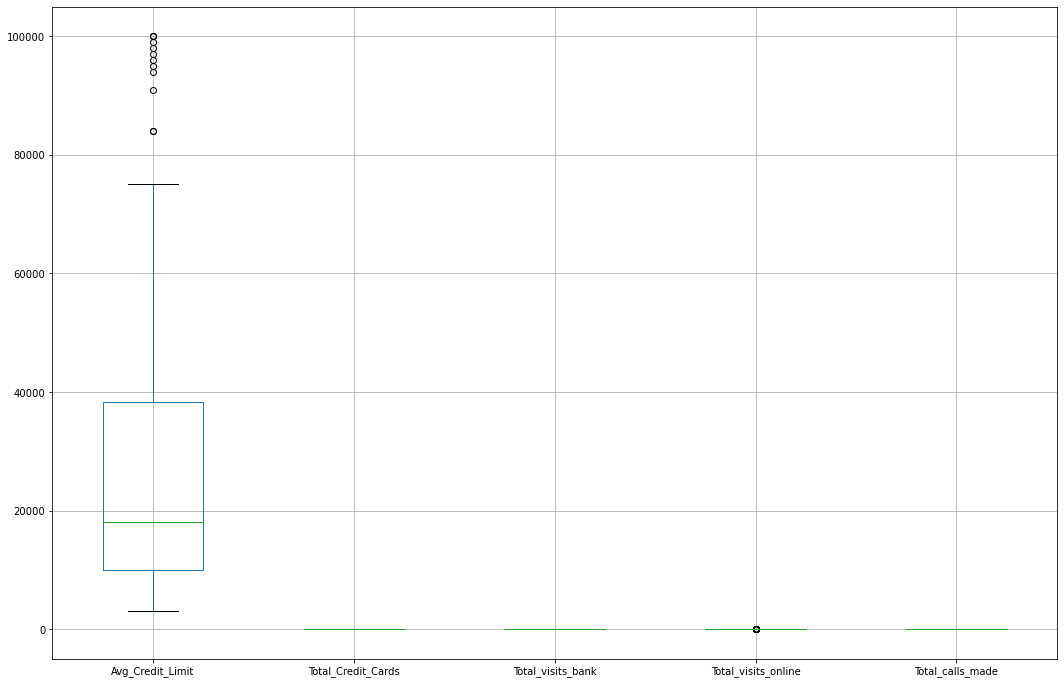

In [25]:
df_work.boxplot(figsize = (18,12))

    The above boxplot proves that the variables belong to different scales.
    Hence, scaling needs to be done to the dataset.

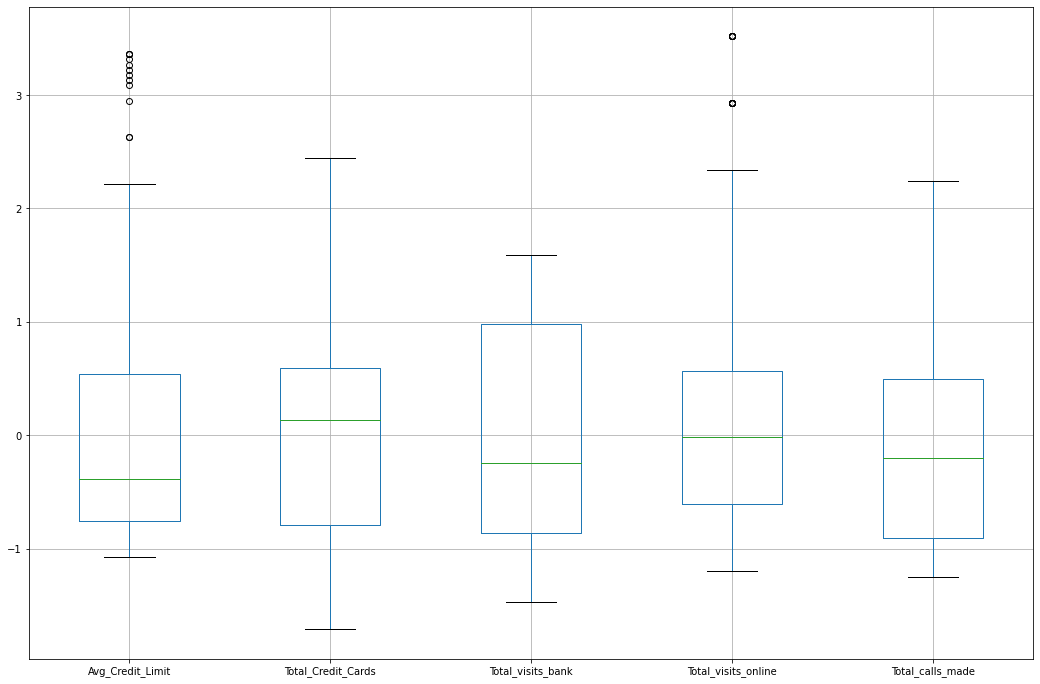

In [26]:
df_scaled = df_work.apply(zscore)

df_scaled.boxplot(figsize = (18,12))

    The above boxplot shows a scaled version of the variables.
    All variables seem to be well within their limits and there are no outliers.

# Pairplots

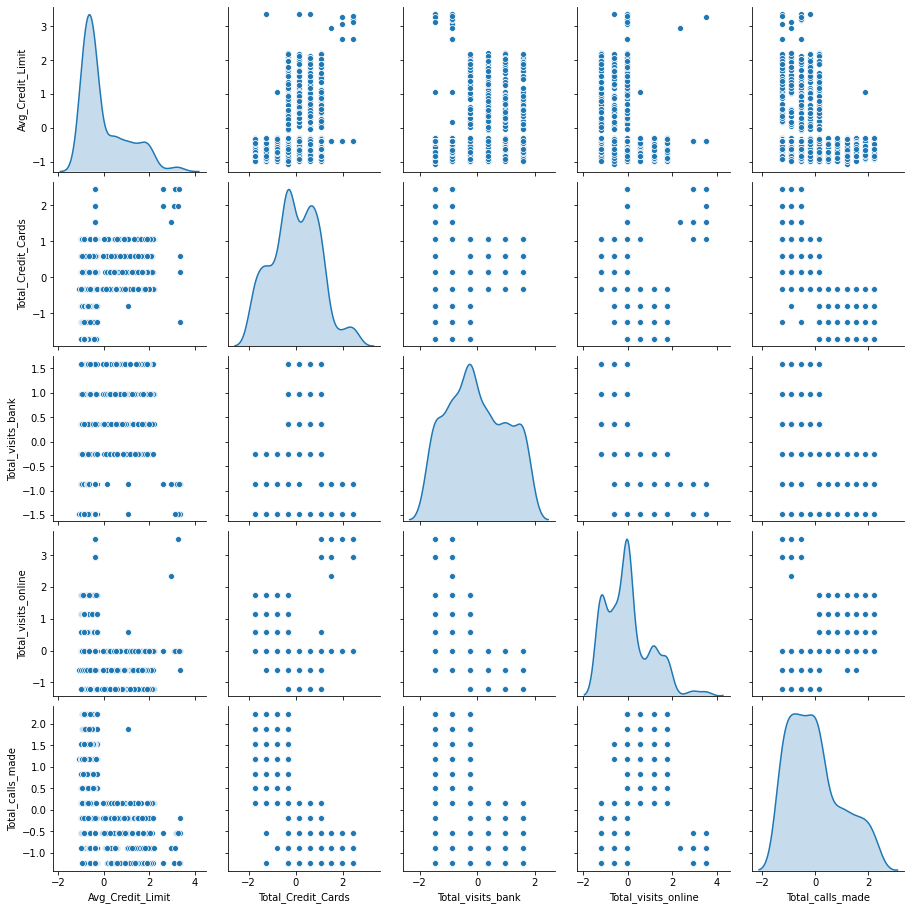

In [27]:
sns.pairplot(df_scaled, diag_kind = 'kde')

# K Means Clustering

    Finding optimal number of clusters

Text(0.5, 1.0, 'Selecting k with the Elbow Method')

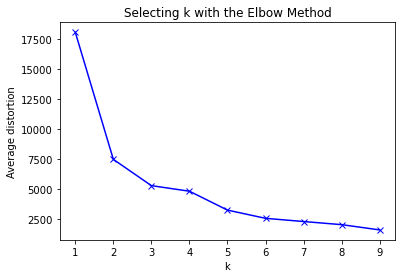

In [28]:
#Finding optimal no. of clusters
from scipy.spatial.distance import cdist
clusters=range(1,10)
meanDistortions=[]

for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(df_work)
    prediction=model.predict(df_work)
    meanDistortions.append(sum(np.min(cdist(df_work, model.cluster_centers_, 'euclidean'), axis=1)) / df_work
                           .shape[0])


plt.plot(clusters, meanDistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average distortion')
plt.title('Selecting k with the Elbow Method')

    Using the elbow method, we see that the curve begins to flatten when the value of K is 6

In [29]:
#Set the value of k=6
kmeans = KMeans(n_clusters=6, n_init = 15, random_state=2345)

In [30]:
kmeans.fit(df_scaled)

KMeans(n_clusters=6, n_init=15, random_state=2345)

In [31]:
centroids = kmeans.cluster_centers_

centroids

array([[-3.32027317e-01,  3.76377966e-01,  4.63653132e-02,
        -6.09464226e-01, -5.38078976e-01],
       [-6.54726525e-01, -1.06749333e+00, -9.02075977e-01,
         8.90399567e-01,  1.16645969e+00],
       [ 1.65476213e+00,  4.71130042e-01,  3.96994274e-01,
        -6.30680200e-01, -5.68081124e-01],
       [ 1.09877672e-01,  1.75143270e+00, -1.07947925e+00,
         3.14000463e+00, -9.52166303e-01],
       [-2.73442295e-01,  3.48506653e-01,  1.31430166e+00,
        -5.80183172e-01, -5.62913146e-01],
       [-3.37610803e-01,  1.88332973e+00, -1.12328498e+00,
         1.40429545e-03, -8.27428360e-01]])

In [32]:
#Calculate the centroids for the columns to profile
df_centroid = pd.DataFrame(centroids, columns = list(df_scaled) )

print(df_centroid)

   Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
0         -0.332027            0.376378           0.046365   
1         -0.654727           -1.067493          -0.902076   
2          1.654762            0.471130           0.396994   
3          0.109878            1.751433          -1.079479   
4         -0.273442            0.348507           1.314302   
5         -0.337611            1.883330          -1.123285   

   Total_visits_online  Total_calls_made  
0            -0.609464         -0.538079  
1             0.890400          1.166460  
2            -0.630680         -0.568081  
3             3.140005         -0.952166  
4            -0.580183         -0.562913  
5             0.001404         -0.827428  


# Observation

    There are 5 groups created from the input data.
    The centroid values of each variable belonging to the respective groups are displayed above.

In [33]:
## creating a new dataframe only for labels and converting it into categorical variable
df_labels = pd.DataFrame(kmeans.labels_ , columns = list(['labels']))

df_labels['labels'] = df_labels['labels'].astype('category')

In [34]:
# Joining the label dataframe with the data frame.
df_labeled = df_main.join(df_labels)

In [35]:
df_analysis = (df_labeled.groupby(['labels'] , axis=0)).head(4177)  # the groupby creates a groupeddataframe that needs 
# to be converted back to dataframe. 
df_analysis.head(10)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,labels
0,100000,2,1,1,0,2
1,50000,3,0,10,9,1
2,50000,7,1,3,4,5
3,30000,5,1,1,4,0
4,100000,6,0,12,3,2
5,20000,3,0,1,8,1
6,100000,5,0,11,2,2
7,15000,3,0,1,1,0
8,5000,2,0,2,2,1
9,3000,4,0,1,7,1


In [36]:
# To find number of values per group

df_labeled['labels'].value_counts()  

1    221
4    141
2    139
0    117
5     28
3     14
Name: labels, dtype: int64

In [37]:
# Let us try with K = 3 (to demonstrate the 3d plot using mplot3d)
from mpl_toolkits.mplot3d import Axes3D

Text(0.5, 0.92, '3D plot of KMeans Clustering')

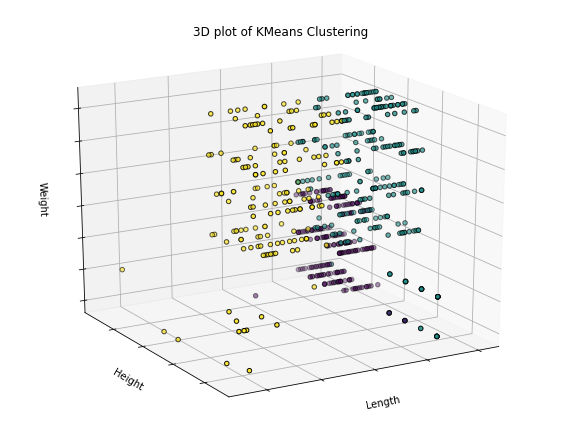

In [38]:
## 3D plots of clusters

fig = plt.figure(figsize=(8, 6))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=20, azim=60)
k3_model=KMeans(3)
k3_model.fit(df_scaled)
labels = k3_model.labels_
ax.scatter(df_scaled.iloc[:, 0], df_scaled.iloc[:, 1], df_scaled.iloc[:, 2],c=labels.astype(np.float), edgecolor='k')
ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Length')
ax.set_ylabel('Height')
ax.set_zlabel('Weight')
ax.set_title('3D plot of KMeans Clustering')

In [39]:
# Let us try with K = 3 (to demonstrate the 3d plot)
final_model=KMeans(3)
final_model.fit(df_main)
prediction=final_model.predict(df_main)

#Append the prediction 
df_main["GROUP"] = prediction
print("Groups Assigned : \n")
df_main[["Avg_Credit_Limit", "GROUP"]].head()

Groups Assigned : 



,Avg_Credit_Limit,GROUP
0,100000,1
1,50000,1
2,50000,1
3,30000,0
4,100000,1


In [40]:
df_main.groupby('GROUP').mean()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
GROUP,,,,,
0,14400.452489,3.932127,2.242081,2.280543,4.436652
1,58588.888889,5.750000,3.177778,1.644444,2.033333
2,155473.684211,8.763158,0.605263,10.947368,1.000000


# K Means Clustering Analysis by BoxPlot

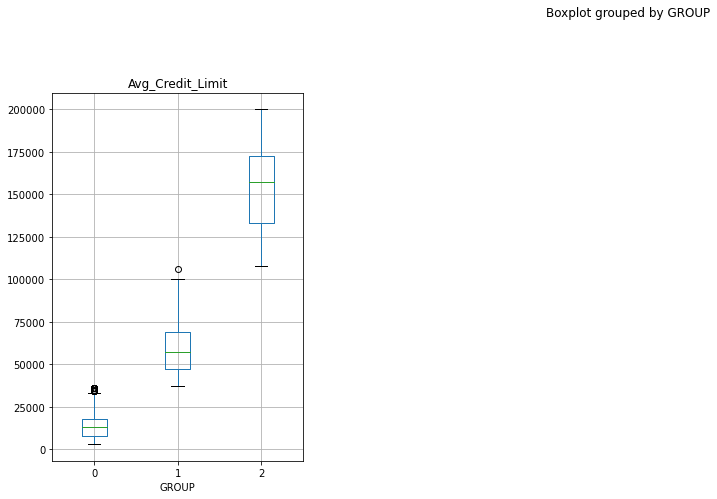

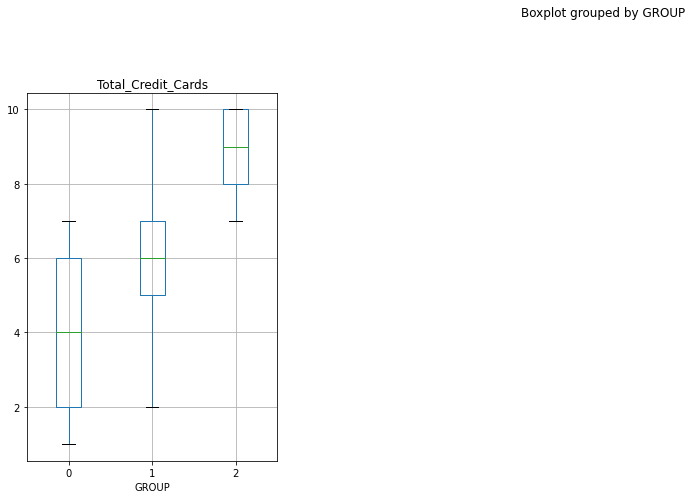

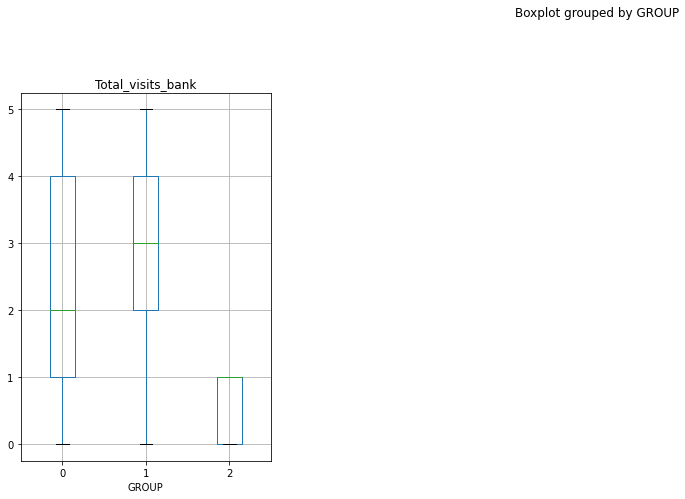

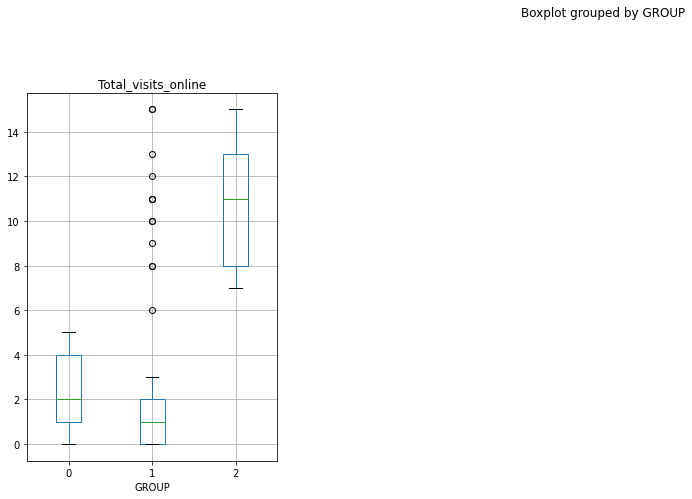

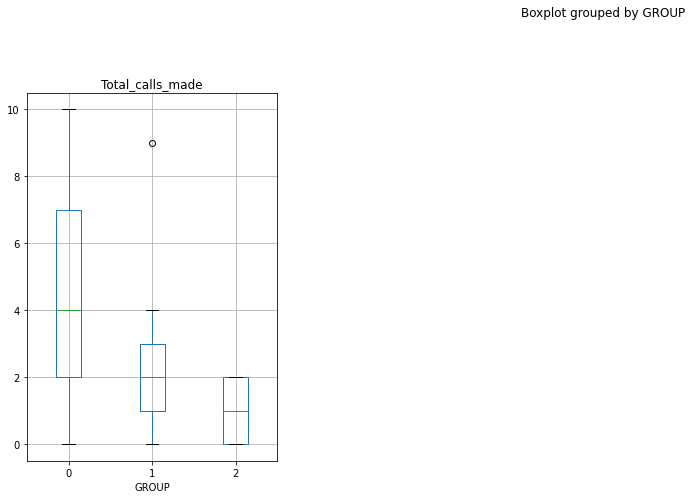

In [41]:
for colname in df_main.columns[:-1]:
    df_main.boxplot(column = df_main[colname].name, by = 'GROUP',  layout=(2,4), figsize=(20, 15))

# K-Means Clustering Groups: Observations

    There are 3 different groups of customers.
    They are classified based on average credit limit, number of credit cards they hold and the method they use to interact with the bank.

# Recommendations


    Group 0
       Average credit limit ~57000 with ~6 credit cards on average.
       Going by the average credit limit and number of credit cards, they are moderate spenders.
       Marketing department needs to concentrate on campaigns selling moderately priced products such as home loans, life insurance etc.
       Most of the customers contact the bank by visiting in person. Hence service improvements for this group need to be done in bank premises such as increased number of touch screens, ticketing system to reduce wait times etc.
       
    Group 1
       Average credit limit ~154200 with ~9 credit cards on average.
       Going by the average credit limit and number of credit cards, they are high spenders.
       Marketing department needs to concentrate on campaigns selling expensive products such as high end auto loans, high net business loans etc.
       Most of the customers contact the bank online. Hence service improvements for this segment need to be concentrated on the website such as reducing the number of clicks, enhancing the UI experience, improving website performance etc.
       
    Group 2
       Average credit limit ~13849 with ~4 credit cards on average.
       Going by the average credit limit and number of credit cards, they are low spenders.
       Marketing department needs to concentrate on campaigns selling products that cost very less such as auto and personal loans.
       Most of the customers contact the bank by phone. Hence service improvements for this segment need to be concentrated on call center resource availability, low wait times, enhancing the IVR experience etc.


# Hierarchical Clustering

In [42]:
# Create new dataset to be used for training by dropping Sl_No & Customer ID
df_mainhc = df_custdata.copy()

df_mainhc.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


In [43]:
# Drop Sl_No
df_mainhc.drop('Sl_No', axis=1, inplace = True)


# Drop Customer Key
df_mainhc.drop('Customer Key', axis=1, inplace = True)

df_mainhc.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,100000,2,1,1,0
1,50000,3,0,10,9
2,50000,7,1,3,4
3,30000,5,1,1,4
4,100000,6,0,12,3


In [44]:
# Treat Outliers

print('-------------------------------------')
for colname in df_mainhc.columns[:-1]:
    q75, q25 = np.percentile(df_mainhc[df_mainhc[colname].name], [75 ,25])
    iqr = q75 - q25
    print('IQR for ',df_mainhc[colname].name,' is:', iqr)
    print('Median for ',df_mainhc[colname].name,' is:', df_mainhc[colname].median())


    limit_lo = q25-1.5*iqr
    limit_uo = q75+1.5*iqr
    print('Lower limit for IQR for',df_mainhc[colname].name,' is: ',limit_lo)
    print('Upper limit for IQR for',df_mainhc[colname].name,' is: ',limit_uo)
    
    print('Replacing outliers of',df_mainhc[colname].name,' with median limit values to assist with grouping')
    df_mainhc.loc[(df_mainhc[colname] < limit_lo) | (df_mainhc[colname] > limit_uo), colname] = df_mainhc[colname].median()
#     df_work.loc[(df_work[colname] < limit_lo), colname] = limit_lo
#     df_work.loc[(df_work[colname] > limit_uo), colname] = limit_uo
    print('-------------------------------------')

-------------------------------------
IQR for  Avg_Credit_Limit  is: 38000.0
Median for  Avg_Credit_Limit  is: 18000.0
Lower limit for IQR for Avg_Credit_Limit  is:  -47000.0
Upper limit for IQR for Avg_Credit_Limit  is:  105000.0
Replacing outliers of Avg_Credit_Limit  with median limit values to assist with grouping
-------------------------------------
IQR for  Total_Credit_Cards  is: 3.0
Median for  Total_Credit_Cards  is: 5.0
Lower limit for IQR for Total_Credit_Cards  is:  -1.5
Upper limit for IQR for Total_Credit_Cards  is:  10.5
Replacing outliers of Total_Credit_Cards  with median limit values to assist with grouping
-------------------------------------
IQR for  Total_visits_bank  is: 3.0
Median for  Total_visits_bank  is: 2.0
Lower limit for IQR for Total_visits_bank  is:  -3.5
Upper limit for IQR for Total_visits_bank  is:  8.5
Replacing outliers of Total_visits_bank  with median limit values to assist with grouping
-------------------------------------
IQR for  Total_visit

In [45]:
df_mainhc.describe().T

,count,mean,std,min,25%,50%,75%,max
Avg_Credit_Limit,660.0,26525.757576,21884.666722,3000.0,10000.0,18000.0,38250.0,100000.0
Total_Credit_Cards,660.0,4.706061,2.167835,1.0,3.0,5.0,6.0,10.0
Total_visits_bank,660.0,2.403030,1.631813,0.0,1.0,2.0,4.0,5.0
Total_visits_online,660.0,2.033333,1.696764,0.0,1.0,2.0,3.0,8.0
Total_calls_made,660.0,3.583333,2.865317,0.0,1.0,3.0,5.0,10.0


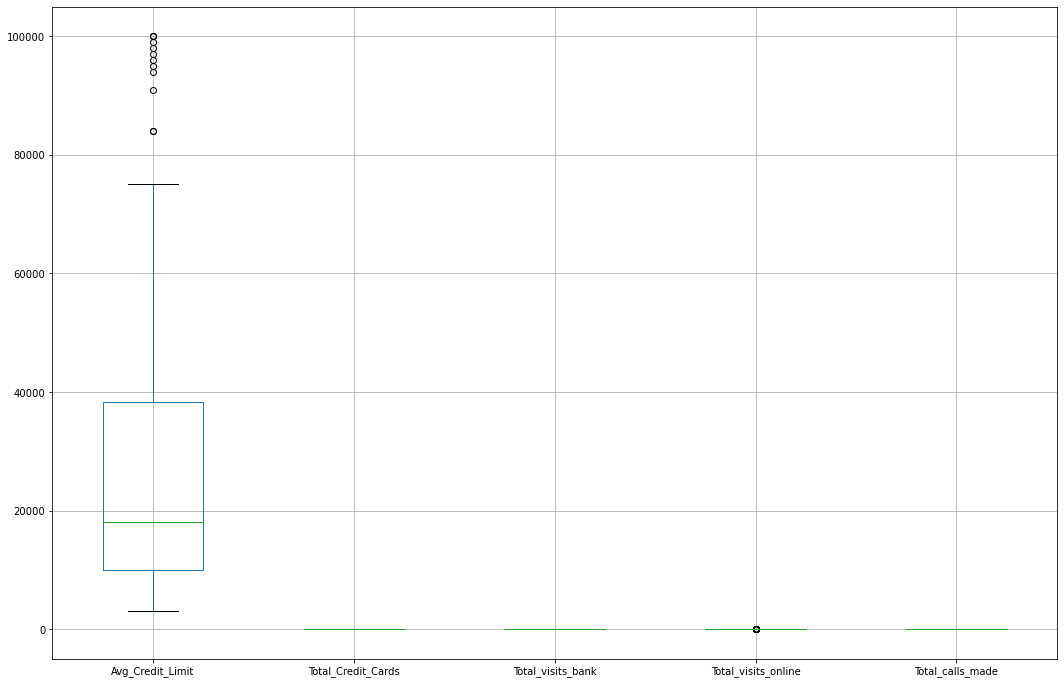

In [46]:
df_mainhc.boxplot(figsize = (18,12))

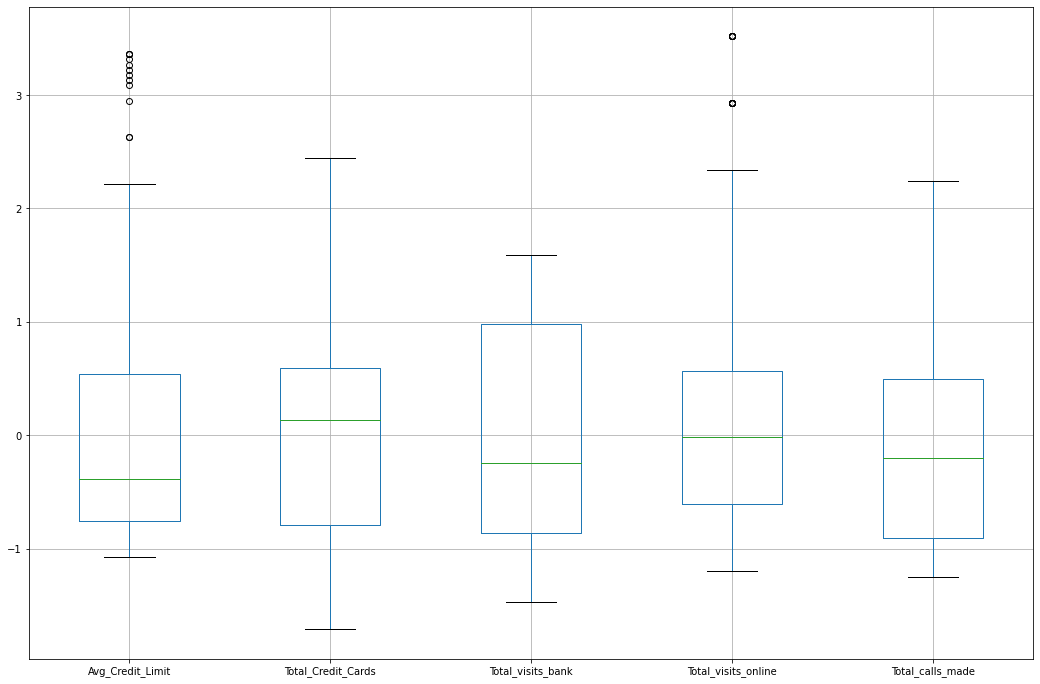

In [47]:
# Data Standardization

df_mainhc_scaled = df_mainhc.apply(zscore)

df_mainhc_scaled.boxplot(figsize = (18,12))

In [48]:
# Create linkage for the scaled data

Z = linkage(df_mainhc_scaled, 'ward', metric='euclidean')
Z.shape

(659, 4)

In [49]:
Z[:]

array([[ 464.        ,  497.        ,    0.        ,    2.        ],
       [ 425.        ,  455.        ,    0.        ,    2.        ],
       [  29.        ,  215.        ,    0.        ,    2.        ],
       ...,
       [1313.        , 1315.        ,   23.72903896,  307.        ],
       [1314.        , 1316.        ,   27.10766583,  437.        ],
       [1312.        , 1317.        ,   54.92935489,  660.        ]])

# Plot the dendrogram for the consolidated dataframe

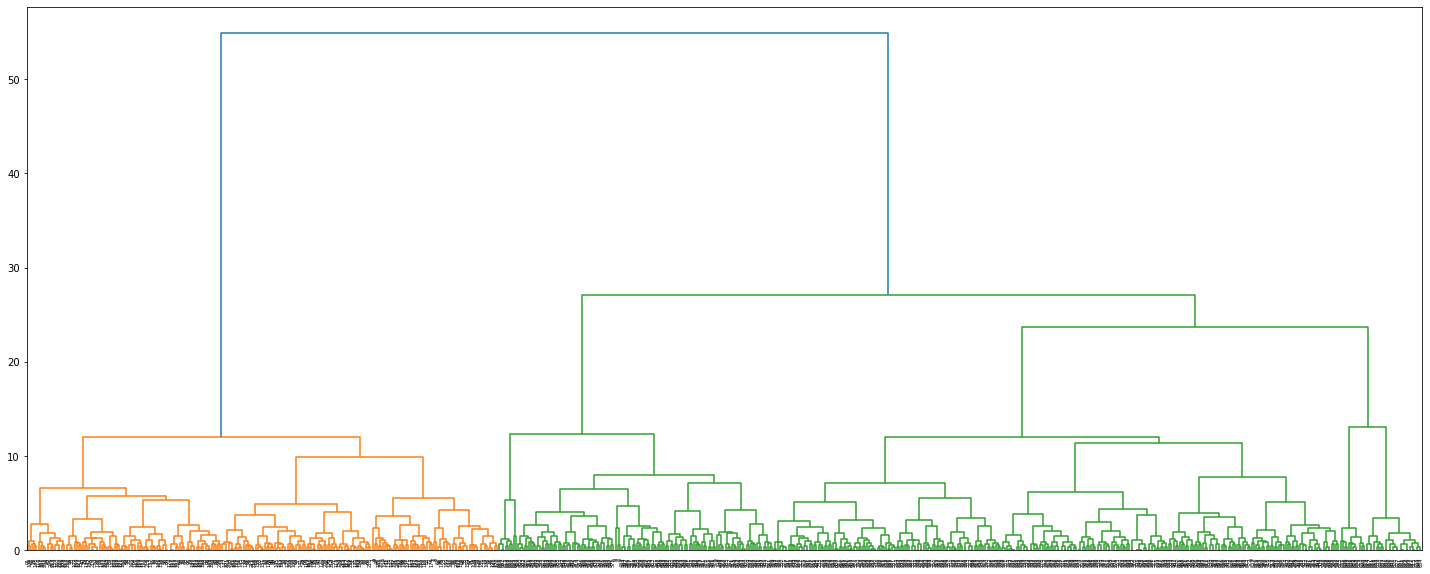

In [50]:
plt.figure(figsize=(25, 10))
dendrogram(Z)
plt.show()

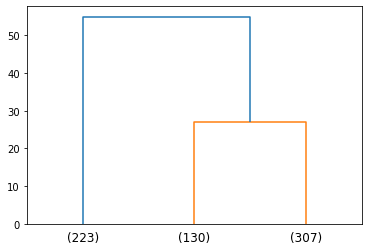

In [51]:
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=3,  # show only the last p merged clusters
)
plt.show()

    Cluster the dataset into 3 groups

In [52]:
max_d = 52

clusters = fcluster(Z, max_d, criterion='distance')
clusters

array([2, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

# Silhouette Index
    
    The Silhouette score indicates the consistency of clustering.

In [53]:
silhouette_score(df_mainhc_scaled,clusters)

0.4315158428061842

Observation

    Silhouette score is ~0.43, which is not closer to 1. Hence it is not a consistent one.

# Hierarchical Clustering - Average

In [54]:
Zhcavg = linkage(df_mainhc_scaled, metric='euclidean', method='average')
c, coph_dists = cophenet(Zhcavg , pdist(df_mainhc_scaled))

c

0.8304715486155523

# Cophenet Index

    cophenet index is a measure of the correlation between the distance of points in feature space and distance on the dendrogram. It usually takes all possible pairs of points in the data and calculates the euclidean distance between the points.
    closer it is to 1, the better is the clustering

    Cophenet Index is ~0.83, which is closer to 1. This indicates a good set of clusters.

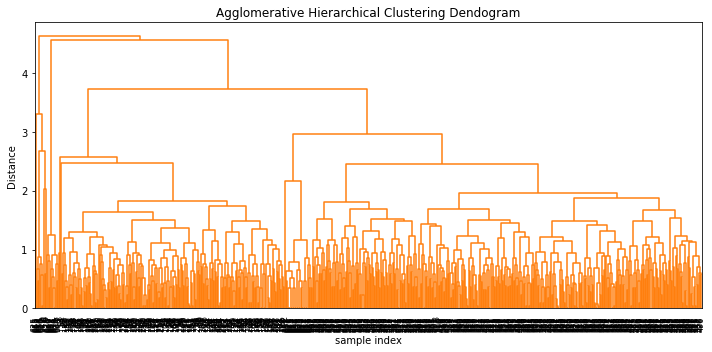

In [55]:
plt.figure(figsize=(10, 5))
plt.title('Agglomerative Hierarchical Clustering Dendogram')
plt.xlabel('sample index')
plt.ylabel('Distance')
dendrogram(Zhcavg, leaf_rotation=90.,color_threshold = 40, leaf_font_size=8. )
plt.tight_layout()

# Hierarchical Clustering - Ward

In [56]:
Zhcw = linkage(df_mainhc_scaled, metric='euclidean', method='ward')
c, coph_dists = cophenet(Zhcw , pdist(df_mainhc_scaled))

c

0.7311173425709666

# Cophenet Index

    Cophenet Index is ~0.73, which is closer to 1, but less than that of the average distance.
 

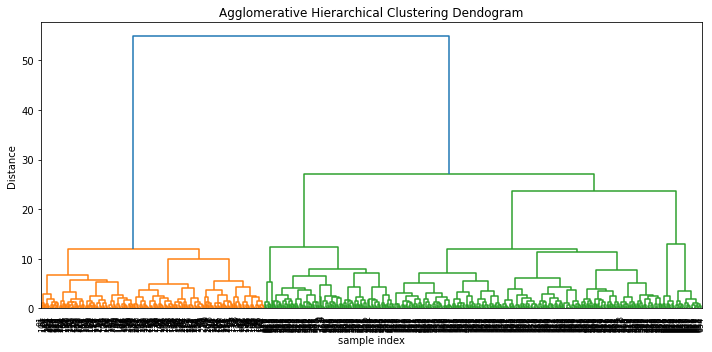

In [57]:
plt.figure(figsize=(10, 5))
plt.title('Agglomerative Hierarchical Clustering Dendogram')
plt.xlabel('sample index')
plt.ylabel('Distance')
dendrogram(Zhcw, leaf_rotation=90.,color_threshold = 40, leaf_font_size=8. )
plt.tight_layout()

# Hierarchical Clustering - Complete

In [58]:
Zhccomp = linkage(df_mainhc_scaled, metric='euclidean', method='complete')
c, coph_dists = cophenet(Zhccomp , pdist(df_mainhc_scaled))

c

0.7883094150879056

# Cophenet Index

    Cophenet Index is ~0.79, which is less than that of average distance but greater than ward. This indicates a good set of clusters.

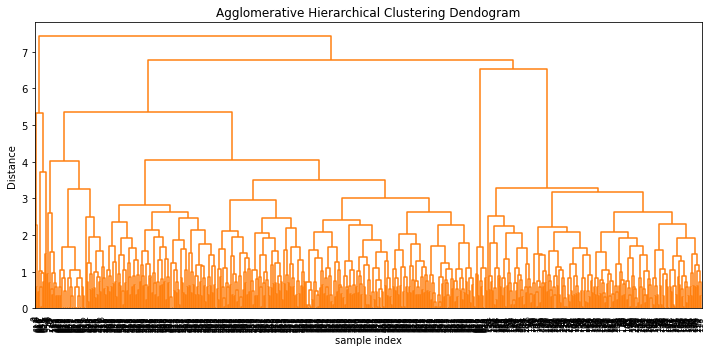

In [59]:
plt.figure(figsize=(10, 5))
plt.title('Agglomerative Hierarchical Clustering Dendogram')
plt.xlabel('sample index')
plt.ylabel('Distance')
dendrogram(Zhccomp, leaf_rotation=90.,color_threshold = 40, leaf_font_size=8. )
plt.tight_layout()

# Comparison of different linkages of Hierarchical Clustering
    With lastp truncating where p = 10

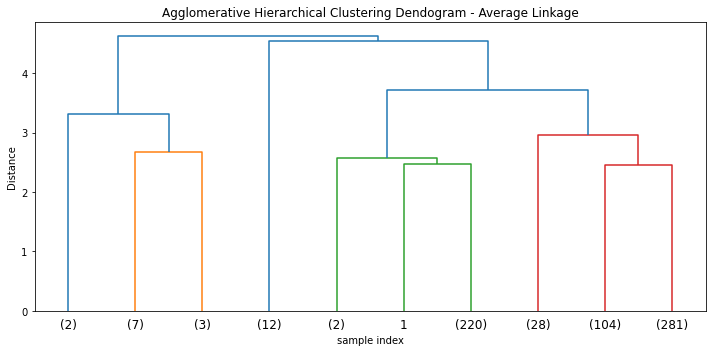

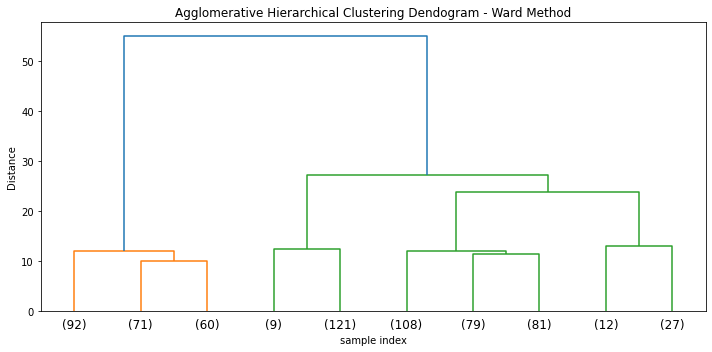

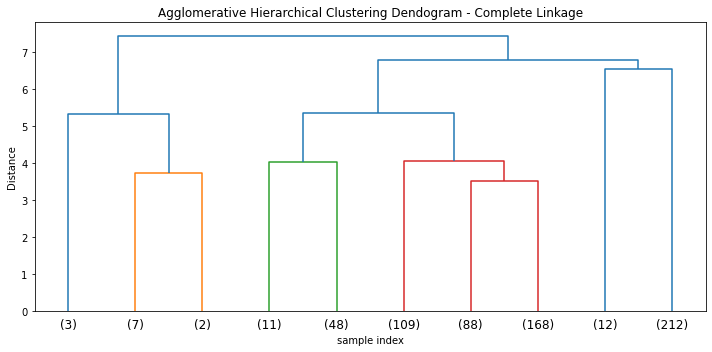

In [60]:
plt.figure(figsize=(10, 5))
plt.title('Agglomerative Hierarchical Clustering Dendogram - Average Linkage')
plt.xlabel('sample index')
plt.ylabel('Distance')
# dendrogram(Zhcavg, leaf_rotation=90.,color_threshold = 40, leaf_font_size=8. )
dendrogram(Zhcavg,truncate_mode='lastp',p=10,)
plt.tight_layout()


plt.figure(figsize=(10, 5))
plt.title('Agglomerative Hierarchical Clustering Dendogram - Ward Method')
plt.xlabel('sample index')
plt.ylabel('Distance')
# dendrogram(Zhcw, leaf_rotation=90.,color_threshold = 40, leaf_font_size=8. )
dendrogram(Zhcw,truncate_mode='lastp',p=10,)
plt.tight_layout()



plt.figure(figsize=(10, 5))
plt.title('Agglomerative Hierarchical Clustering Dendogram - Complete Linkage')
plt.xlabel('sample index')
plt.ylabel('Distance')
# dendrogram(Zhccomp, leaf_rotation=90.,color_threshold = 40, leaf_font_size=8. )
dendrogram(Zhccomp,truncate_mode='lastp',p=10,)
plt.tight_layout()

# 3D Plots for Hierarchical Clustering with the various methods
    
    - Create new datasets to group records according to the different methods
    - Create 3D plots to visualize how the groups are laid out with respect to each other on the 3D planes

# Group dataset by Hierarchical Clustering using Average Distance

In [61]:
df_mainhc_avg = df_mainhc_scaled.copy()

df_mainhc_avg.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,3.359885,-1.249225,-0.860451,-0.609464,-1.251537
1,1.073448,-0.787585,-1.473731,-0.019660,1.891859
2,1.073448,1.058973,-0.860451,0.570144,0.145528
3,0.158873,0.135694,-0.860451,-0.609464,0.145528
4,3.359885,0.597334,-1.473731,-0.019660,-0.203739


In [62]:
modelhcavg = AgglomerativeClustering(n_clusters=3, affinity='euclidean',linkage='average')
modelhcavg.fit(df_mainhc_avg)
df_mainhc_avg['labels'] = modelhcavg.labels_
df_mainhc_avg.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,labels
0,3.359885,-1.249225,-0.860451,-0.609464,-1.251537,1
1,1.073448,-0.787585,-1.473731,-0.019660,1.891859,0
2,1.073448,1.058973,-0.860451,0.570144,0.145528,0
3,0.158873,0.135694,-0.860451,-0.609464,0.145528,0
4,3.359885,0.597334,-1.473731,-0.019660,-0.203739,1


# Group dataset by Hierarchical Clustering using Ward Method

In [63]:
df_mainhc_ward = df_mainhc_scaled.copy()

df_mainhc_ward.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,3.359885,-1.249225,-0.860451,-0.609464,-1.251537
1,1.073448,-0.787585,-1.473731,-0.019660,1.891859
2,1.073448,1.058973,-0.860451,0.570144,0.145528
3,0.158873,0.135694,-0.860451,-0.609464,0.145528
4,3.359885,0.597334,-1.473731,-0.019660,-0.203739


In [64]:
modelhcward = AgglomerativeClustering(n_clusters=3, affinity='euclidean',linkage='ward')
modelhcward.fit(df_mainhc_ward)
df_mainhc_ward['labels'] = modelhcward.labels_
df_mainhc_ward.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,labels
0,3.359885,-1.249225,-0.860451,-0.609464,-1.251537,2
1,1.073448,-0.787585,-1.473731,-0.019660,1.891859,1
2,1.073448,1.058973,-0.860451,0.570144,0.145528,2
3,0.158873,0.135694,-0.860451,-0.609464,0.145528,0
4,3.359885,0.597334,-1.473731,-0.019660,-0.203739,2


# Group dataset by Hierarchical Clustering using Complete Distance

In [65]:
df_mainhc_cmplt = df_mainhc_scaled.copy()

df_mainhc_cmplt.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,3.359885,-1.249225,-0.860451,-0.609464,-1.251537
1,1.073448,-0.787585,-1.473731,-0.019660,1.891859
2,1.073448,1.058973,-0.860451,0.570144,0.145528
3,0.158873,0.135694,-0.860451,-0.609464,0.145528
4,3.359885,0.597334,-1.473731,-0.019660,-0.203739


In [66]:
modelhccmplt = AgglomerativeClustering(n_clusters=3, affinity='euclidean',linkage='complete')
modelhccmplt.fit(df_mainhc_cmplt)
df_mainhc_cmplt['labels'] = modelhccmplt.labels_
df_mainhc_cmplt.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,labels
0,3.359885,-1.249225,-0.860451,-0.609464,-1.251537,1
1,1.073448,-0.787585,-1.473731,-0.019660,1.891859,0
2,1.073448,1.058973,-0.860451,0.570144,0.145528,2
3,0.158873,0.135694,-0.860451,-0.609464,0.145528,2
4,3.359885,0.597334,-1.473731,-0.019660,-0.203739,1


## 3D plots of clusters

Text(0.5, 0.92, '3D plot of Hierarchical Clustering using Complete Distance')

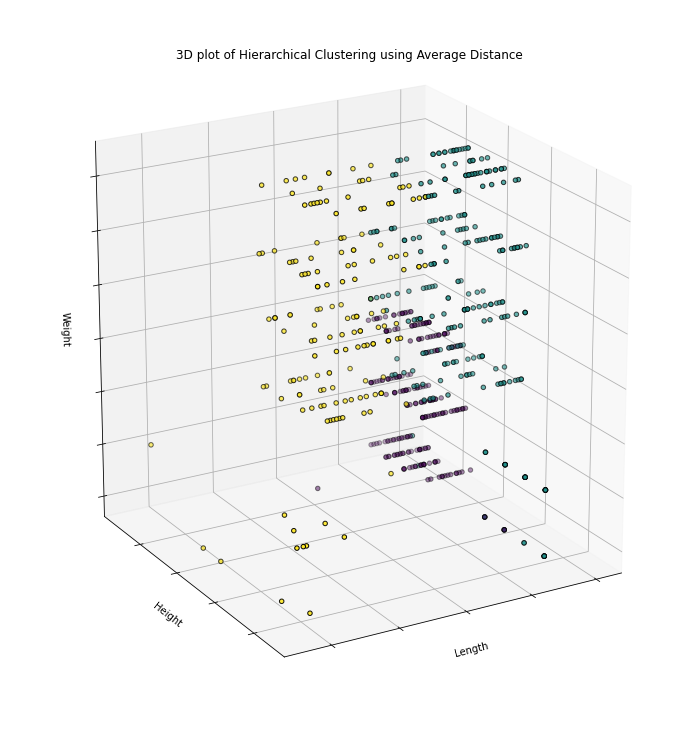

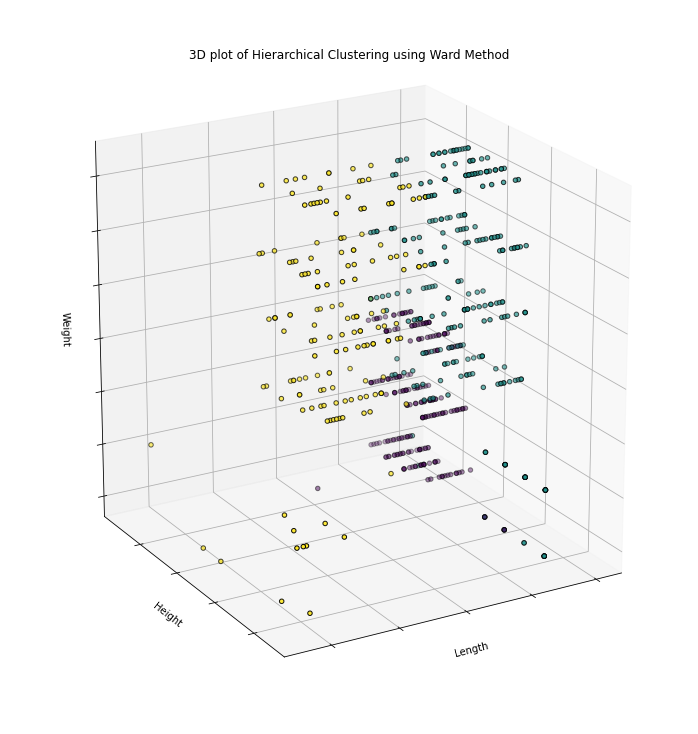

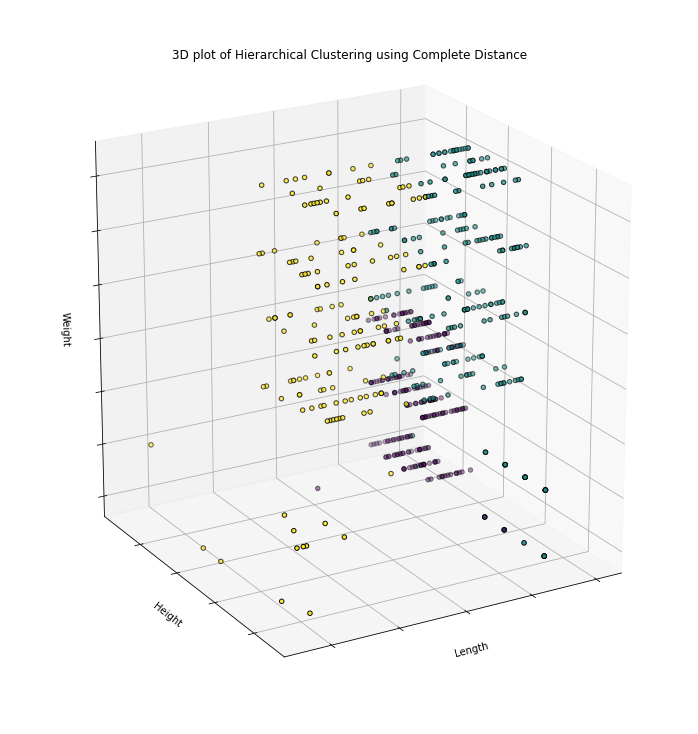

In [67]:
# Average Distance
fig = plt.figure(figsize=(10, 10))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=20, azim=60)
ax.scatter(df_mainhc_avg.iloc[:, 0], df_mainhc_avg.iloc[:, 1], df_mainhc_avg.iloc[:, 2],c=labels.astype(np.float), edgecolor='k')
ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Length')
ax.set_ylabel('Height')
ax.set_zlabel('Weight')
ax.set_title('3D plot of Hierarchical Clustering using Average Distance')


# Ward Method
fig = plt.figure(figsize=(10, 10))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=20, azim=60)
ax.scatter(df_mainhc_ward.iloc[:, 0], df_mainhc_ward.iloc[:, 1], df_mainhc_ward.iloc[:, 2],c=labels.astype(np.float), edgecolor='k')
ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Length')
ax.set_ylabel('Height')
ax.set_zlabel('Weight')
ax.set_title('3D plot of Hierarchical Clustering using Ward Method')

# Complete Distance
fig = plt.figure(figsize=(10, 10))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=20, azim=60)
ax.scatter(df_mainhc_cmplt.iloc[:, 0], df_mainhc_cmplt.iloc[:, 1], df_mainhc_cmplt.iloc[:, 2],c=labels.astype(np.float), edgecolor='k')
ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Length')
ax.set_ylabel('Height')
ax.set_zlabel('Weight')
ax.set_title('3D plot of Hierarchical Clustering using Complete Distance')

# Comparison of the 3 cluster methods using boxplot with original data

# Average Distance

In [68]:
df_finalhc_avg = df_mainhc.copy()
df_finalhc_avg['labels'] = modelhcavg.labels_
df_finalhc_avg.head()



,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,labels
0,100000.0,2.0,1.0,1.0,0,1
1,50000.0,3.0,0.0,2.0,9,0
2,50000.0,7.0,1.0,3.0,4,0
3,30000.0,5.0,1.0,1.0,4,0
4,100000.0,6.0,0.0,2.0,3,1


In [69]:
df_finalhc_avg.labels.value_counts()

0    636
2     12
1     12
Name: labels, dtype: int64

In [70]:
df_finalhc_avg.groupby('labels').mean()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
labels,,,,,
0,25397.798742,4.569182,2.468553,1.918239,3.680818
1,94833.333333,8.166667,0.666667,2.750000,1.250000
2,18000.000000,8.500000,0.666667,7.416667,0.750000


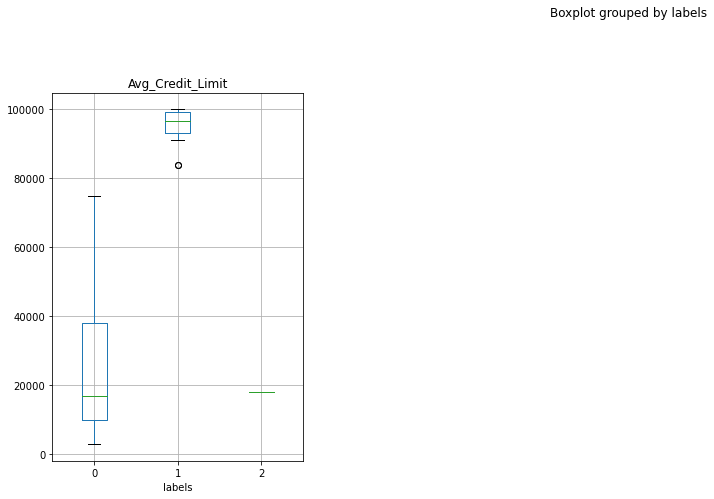

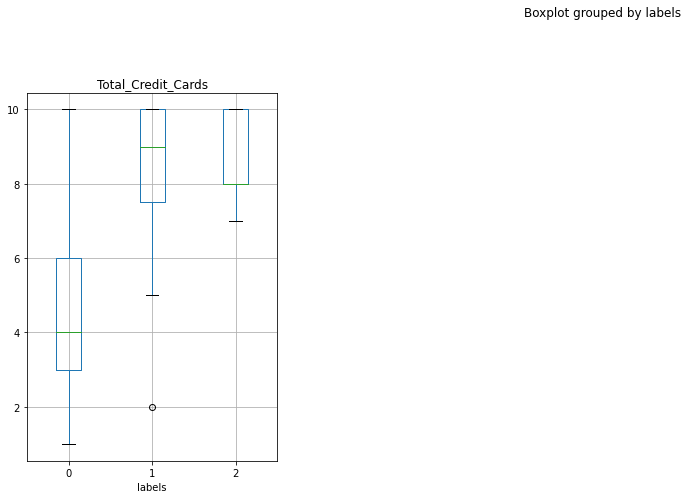

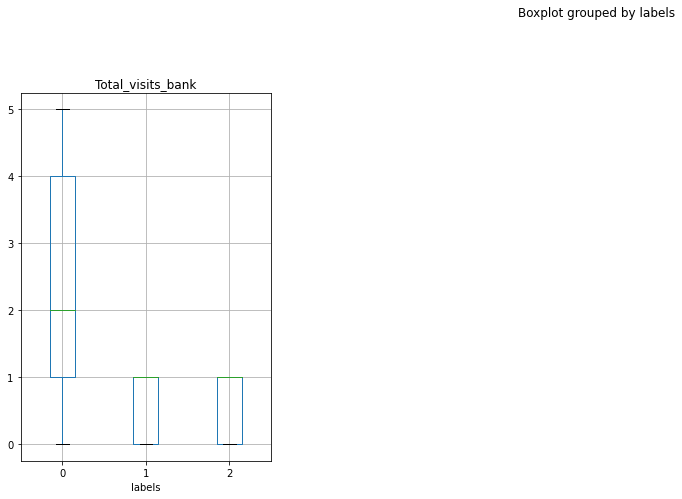

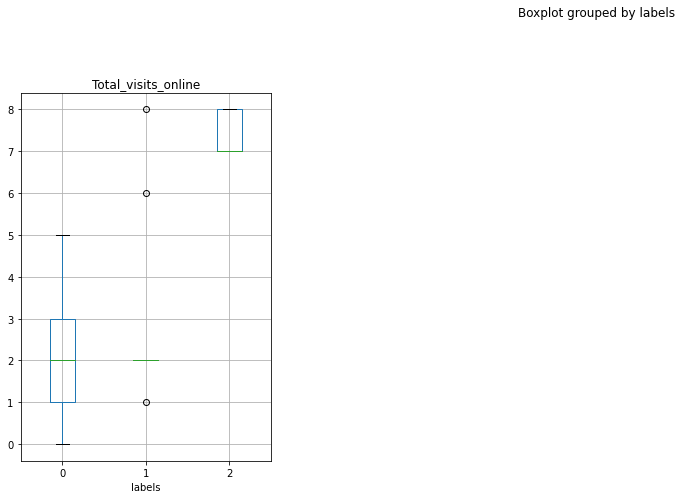

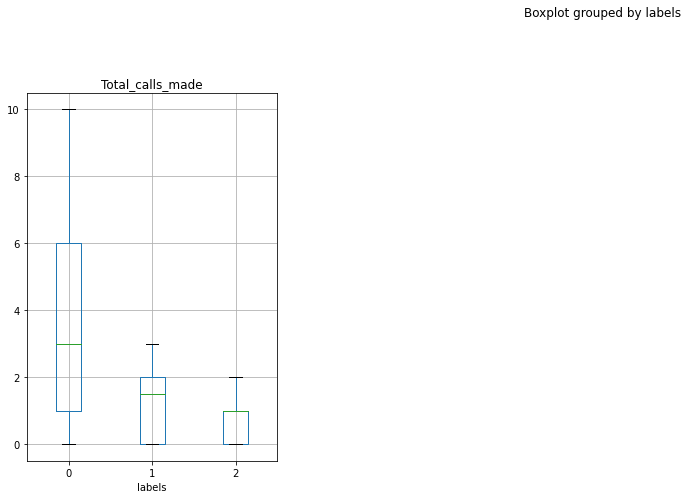

In [71]:
for colname in df_finalhc_avg.columns[:-1]:
    df_finalhc_avg.boxplot(column = df_finalhc_avg[colname].name, by = 'labels',  layout=(2,4), figsize=(20, 15))

# Hierarchical Clustering Groups: Observations

# Average Distance

    There are 3 different groups of customers.
    They are classified based on average credit limit, number of credit cards they hold and the method they use to interact with the bank.

# Recommendations

    Group 0
       Average credit limit ~25000 with ~5 credit cards on average.
       Going by the average credit limit and number of credit cards, they are moderate spenders.
       Marketing department needs to concentrate on campaigns selling moderately priced products such as home loans, life insurance etc.
       Most of the customers contact the bank by phone. Hence service improvements for this segment need to be concentrated on call center resource availability, low wait times, enhancing the IVR experience etc. 

    Group 1
       Average credit limit ~95000 with ~8 credit cards on average.
       Going by the average credit limit and number of credit cards, they are high spenders.
       Marketing department needs to concentrate on campaigns selling expensive products such as high end auto loans, high net business loans etc.
       Most of the customers contact the bank online. Hence service improvements for this segment need to be concentrated on the website such as reducing the number of clicks, enhancing the UI experience, improving website performance etc.

    Group 2
       Average credit limit ~18000 with ~8 credit cards on average.
       Going by the average credit limit and number of credit cards, they are low spenders.
       Marketing department needs to concentrate on campaigns selling products that cost very less such as auto and personal loans.
       Most of the customers contact the bank online. Hence service improvements for this segment need to be concentrated on the website such as reducing the number of clicks, enhancing the UI experience, improving website performance etc.

# Ward Method

In [72]:
df_finalhc_ward = df_mainhc.copy()
df_finalhc_ward['labels'] = modelhcward.labels_
df_finalhc_ward.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,labels
0,100000.0,2.0,1.0,1.0,0,2
1,50000.0,3.0,0.0,2.0,9,1
2,50000.0,7.0,1.0,3.0,4,2
3,30000.0,5.0,1.0,1.0,4,0
4,100000.0,6.0,0.0,2.0,3,2


In [73]:
df_finalhc_ward.labels.value_counts()

0    307
1    223
2    130
Name: labels, dtype: int64

In [74]:
df_finalhc_ward.groupby('labels').mean()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
labels,,,,,
0,20947.882736,5.885993,3.247557,1.390879,1.833876
1,12197.309417,2.403587,0.928251,3.524664,6.883408
2,64276.923077,5.869231,2.938462,0.992308,2.053846


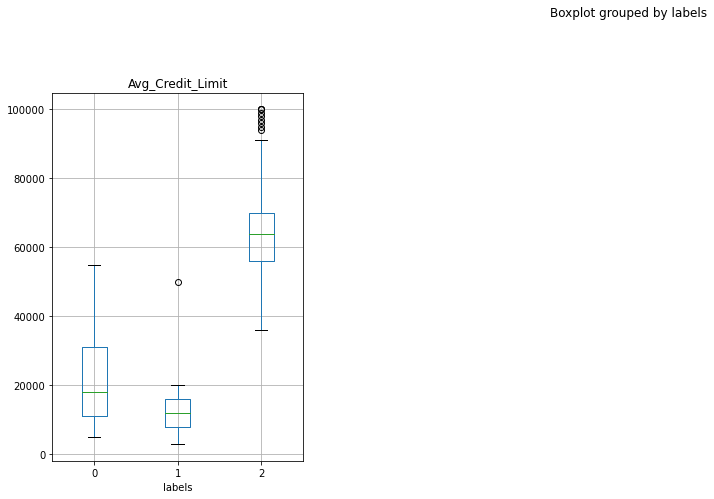

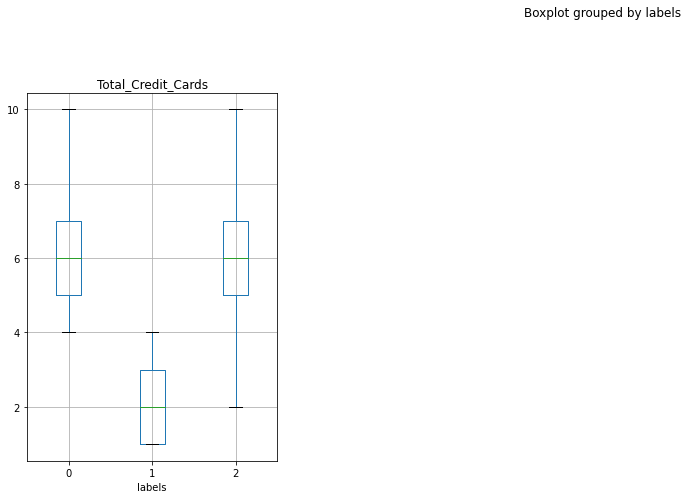

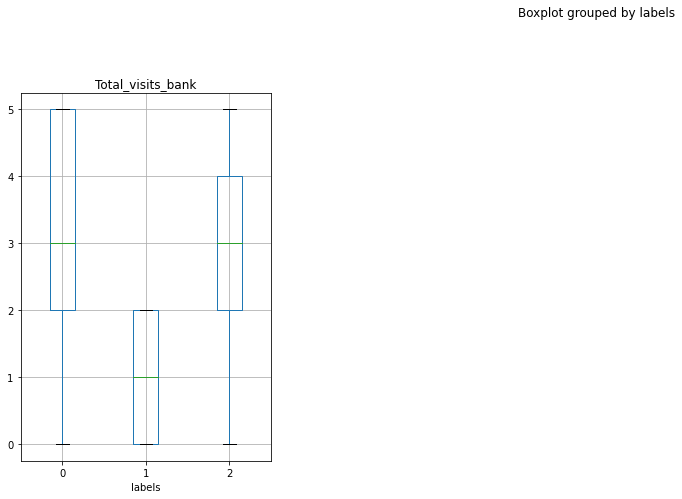

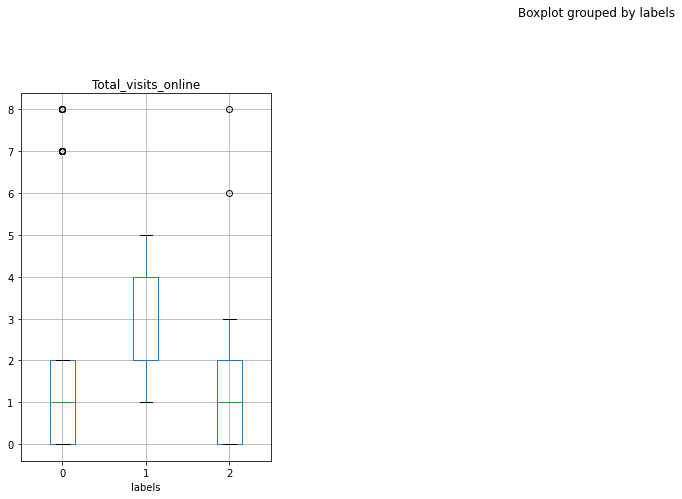

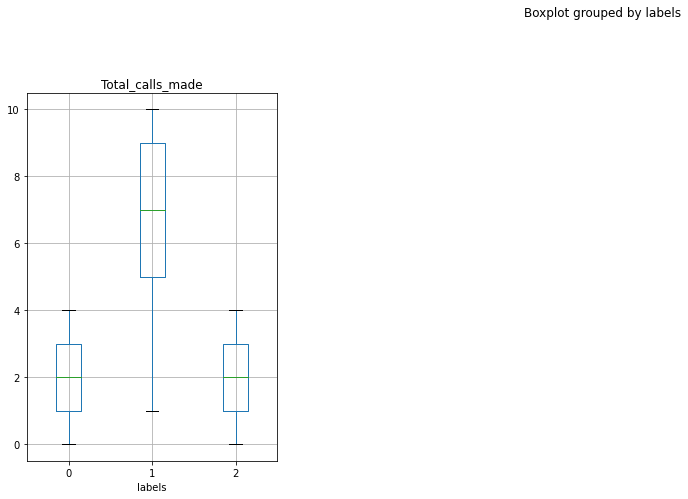

In [75]:
for colname in df_finalhc_ward.columns[:-1]:
    df_finalhc_ward.boxplot(column = df_finalhc_ward[colname].name, by = 'labels',  layout=(2,4), figsize=(20, 15))

# Hierarchical Clustering Groups: Observations

# Ward Method

    There are 3 different groups of customers.
    They are classified based on average credit limit, number of credit cards they hold and the method they use to interact with the bank.

# Recommendations

    Group 0
       Average credit limit ~21000 with ~6 credit cards on average.
       Going by the average credit limit and number of credit cards, they are moderate spenders.
       Marketing department needs to concentrate on campaigns selling moderately priced products such as home loans, life insurance etc.
       Most of the customers contact the bank by visiting in person. Hence service improvements for this group need to be done in bank premises such as increased number of touch screens, ticketing system to reduce wait times etc.

    Group 1
       Average credit limit ~12000 with ~2 credit cards on average.
       Going by the average credit limit and number of credit cards, they are low spenders.
       Marketing department needs to concentrate on campaigns selling products that cost very less such as auto and personal loans.
       Most of the customers contact the bank by phone. Hence service improvements for this segment need to be concentrated on call center resource availability, low wait times, enhancing the IVR experience etc.

    Group 2
       Average credit limit ~64000 with ~6 credit cards on average.
       Going by the average credit limit and number of credit cards, they are high spenders.
       Marketing department needs to concentrate on campaigns selling expensive products such as high end auto loans, high net business loans etc.
       Most of the customers contact the bank by visiting in person. Hence service improvements for this group need to be done in bank premises such as increased number of touch screens, ticketing system to reduce wait times etc.

# Complete Distance

In [76]:
df_finalhc_cmplt = df_mainhc.copy()
df_finalhc_cmplt['labels'] = modelhccmplt.labels_
df_finalhc_cmplt.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,labels
0,100000.0,2.0,1.0,1.0,0,1
1,50000.0,3.0,0.0,2.0,9,0
2,50000.0,7.0,1.0,3.0,4,2
3,30000.0,5.0,1.0,1.0,4,2
4,100000.0,6.0,0.0,2.0,3,1


In [77]:
df_finalhc_cmplt.labels.value_counts()

2    424
0    224
1     12
Name: labels, dtype: int64

In [78]:
df_finalhc_cmplt.groupby('labels').mean()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
labels,,,,,
0,12647.321429,2.669643,0.946429,3.816964,6.660714
1,94833.333333,8.166667,0.666667,2.750000,1.250000
2,31924.528302,5.683962,3.221698,1.070755,2.023585


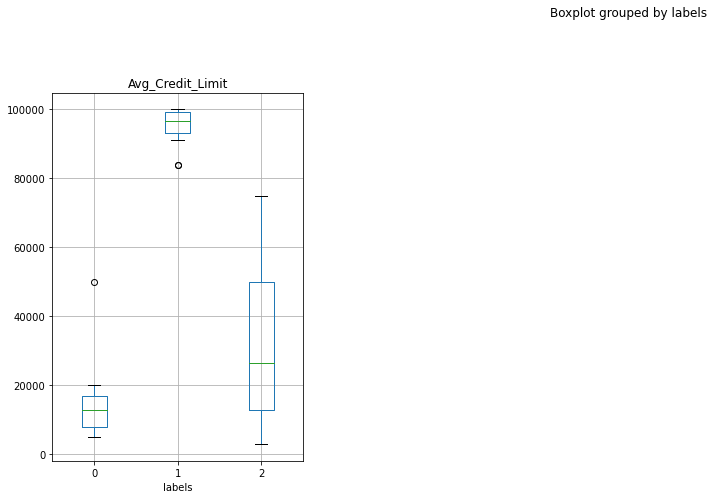

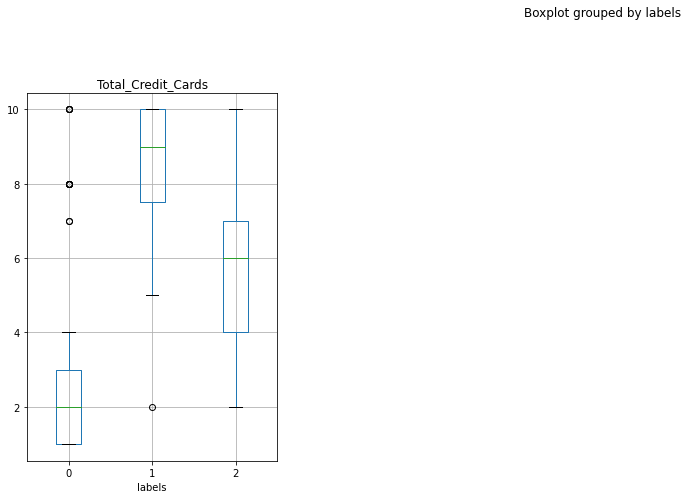

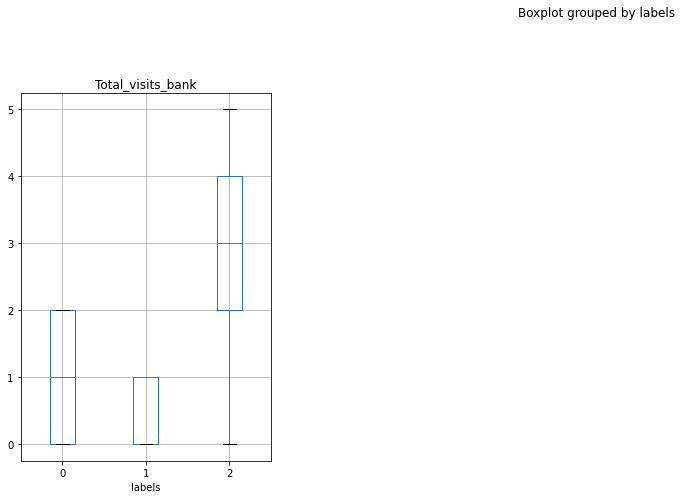

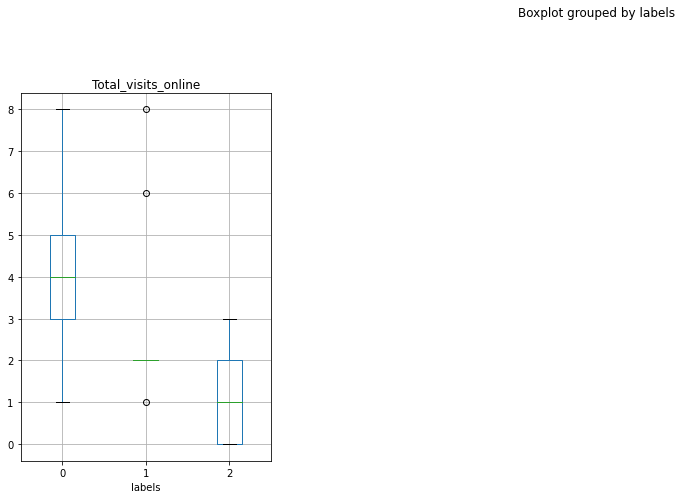

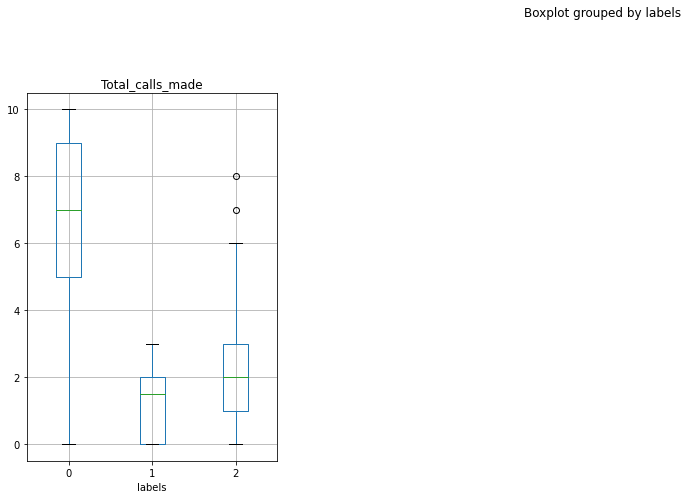

In [79]:
for colname in df_finalhc_cmplt.columns[:-1]:
    df_finalhc_cmplt.boxplot(column = df_finalhc_cmplt[colname].name, by = 'labels',  layout=(2,4), figsize=(20, 15))

# Hierarchical Clustering Groups: Observations

# Complete Distance

    There are 3 different groups of customers.
    They are classified based on average credit limit, number of credit cards they hold and the method they use to interact with the bank.

# Recommendations

    Group 0
       Average credit limit ~13000 with ~3 credit cards on average.
       Going by the average credit limit and number of credit cards, they are low spenders.
       Marketing department needs to concentrate on campaigns selling products that cost very less such as auto and personal loans.
       Most of the customers contact the bank by phone. Hence service improvements for this segment need to be concentrated on call center resource availability, low wait times, enhancing the IVR experience etc.

    Group 1
       Average credit limit ~95000 with ~8 credit cards on average.
       Going by the average credit limit and number of credit cards, they are high spenders.
       Marketing department needs to concentrate on campaigns selling expensive products such as high end auto loans, high net business loans etc.
       Most of the customers contact the bank online. Hence service improvements for this segment need to be concentrated on the website such as reducing the number of clicks, enhancing the UI experience, improving website performance etc.

    Group 2
       Average credit limit ~32000 with ~6 credit cards on average.
       Going by the average credit limit and number of credit cards, they are moderate spenders.
       Marketing department needs to concentrate on campaigns selling moderately priced products such as home loans, life insurance etc.
       Most of the customers contact the bank by visiting in person. Hence service improvements for this group need to be done in bank premises such as increased number of touch screens, ticketing system to reduce wait times etc.